##### Version 0.2 -- March 2014

# Flow over a cylinder with source-panels

In previous lessons, we used potential-flow singularities of defined strength to represent the shape of simple geometries, such as a [Rankine oval](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/02_Lesson02_sourceSinkFreestream.ipynb) or a [circular cylinder](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/03_Lesson03_doublet.ipynb), immersed in a free stream. We were rather lucky that when superposing a few fundamental potential-flow solutions, the stream-line pattern that resulted had a closed dividing stream line that we could interpret as a solid body.

But what if we want to represent the stream lines around an *arbitrary* geometry? Would you be able to define the combination of fundamental solutions to get the expected result? *How could you do that?* Trial and error? It would take enormous luck and a lot of work to get a geometry we want.

In this lesson, the objective is to calculate the source-strength distribution that can produce potential flow around a given geometry: a circular cylinder. We know that we can get the flow around a cylider by superposing a doublet in a free stream, but here we want to develop a more general approach that can later be extended to *different* shapes.

The method we will use consists of representing the geometry of the body by a series of short linear segments, called *panels*, that correspond to [source sheets](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/08_Lesson08_sourceSheet.ipynb) like we studied in the previous lesson.

What we are aiming for is a method that starts with a defined body geometry, then works out the strength of sources needed in each panel representing that geometry to get a dividing streamline right on the body boundary. We will have to *solve* for the source strengths by specifying that the body be a streamline, i.e., the velocity be tangent there.

Let's start by loading the Python libraries that we will need in this notebook.

In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

We will add a uniform horizontal flow of magnitude `u_inf`, so let's make that equal to 1:

In [2]:
u_inf = 1.0             # free-stream speed

### Definition of the geometry

The geometry considered here will be a circular cylinder of unit radius. We can define this geometry very easily by a set of points going around the angular range between $0$ and $2\pi$.

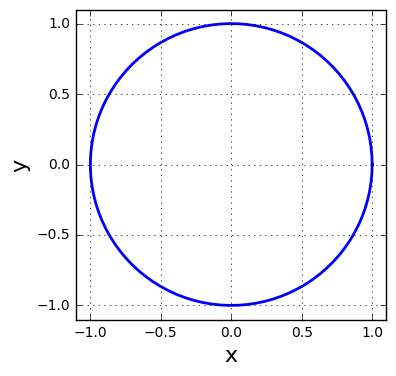

In [3]:
# defines the cylinder
R = 1.0                                                     # radius
theta = numpy.linspace(0, 2*math.pi, 100)                           # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder

# plots the cylinder
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Discretization into panels

A panel, which represents a source sheet, is defined by its two end-points (`xa`, `ya`) and (`xb`, `yb`) and its strength `sigma`. We'll also need its center point (`xc`, `yc`) and its length for further calculations. The orientation of the panel is defined by the angle between the $x$-axis and its normal in the counter-clockwise sense.

What information do we need to compute on each panel? First of all, we will need the strength of the source sheet that will lead to the correct streamlines. In addition, we'll also want the tangential velocity (the normal velocity on the body is zero for an inviscid flow) and the pressure coefficient.

In this lesson, you'll really appreciate having learned about classes. It will make the code so much easier to manage. We create a class named `Panel` containing all the geometry data related to one panel. With a start- and end-point, the class internally calculates the center-point, length and normal vector. It also initializes to zero the source strength, tangential velocity and pressure coefficient. (These will be updated later.)

In [4]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

To store all the discretization, we create a NumPy array of size `N_panels` where each item in the array is an object of type `Panel`.

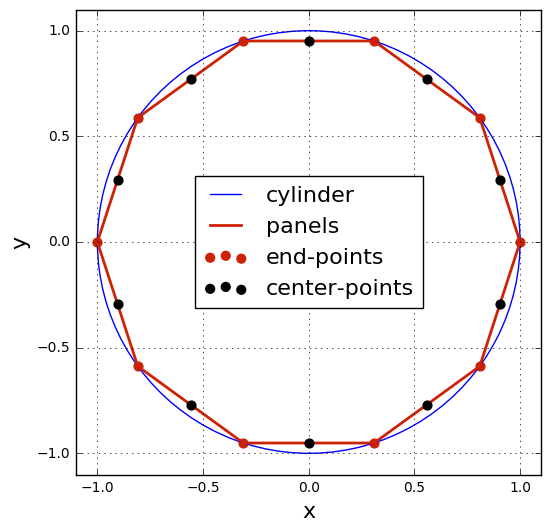

In [5]:
N_panels = 10                    # number of panels desired

# defining the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# defining the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plotting the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Flow-tangency boundary condition

In [Lesson 1](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/01_Lesson01_sourceSink.ipynb), you worked out the velocity potential of a single source as part of the final *Challenge  Task.* It followed simply from integrating the radial velocity, $u_r=\frac{\sigma}{2\pi r}$, that

$$\phi=\frac{\sigma}{2\pi}\ln r$$

(The integration also gives a function of $\theta$ that is seen to be a constant because $u_{\theta}=0$; we take this constant to be zero.)

We will use the velocity potential in this lesson to easily express that the velocity be tangent at the panel, i.e., that $u_n=0$ with:

$$u_n(x,y)=\frac{\partial \phi}{\partial n}(x,y)$$

at a given point on the panel. We choose the point to enforce that velocity-tangency condition as the center of the panel (and we call it the *control point*).

The velocity potential in Cartesian coordinates of a [source sheet](http://nbviewer.ipython.org/urls/github.com/barbagroup/AeroPython/blob/master/lessons/08_Lesson08_sourceSheet.ipynb) on a panel is

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi} \int_\text{panel} \ln \sqrt{ \left(x-x(s)\right)^2 + \left(y-y(s)\right)^2 } {\rm d}s$$

where $s$ is the running coordinate along the panel and $\left(x(s),y(s)\right)$ are the Cartesian coordinates of $s$.

Superposition of the potential of each panel gives the total potential at any point $\left(x,y\right)$, so we make a sum of all the panel contributions as follows (moving the $\frac{1}{2}$ exponent in the logarithmic term as a factor outside the integral):

$$\phi\left(x,y\right) = \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

By finally superposing the free stream, the flow around an immersed circular cylinder will be represented by the following velocity potential:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

Enforcing the flow-tangency condition on each *control point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represented the body with more and more panels). So, for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$:

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0$$

which leads to

$$0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial n_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial n_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

where $\beta_i$ is the angle that the panel's normal makes with the $x$-axis, so

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{and}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

and

$$x_j(s_j) = x_{a_j} - \sin\left(\beta_j\right) s_j$$
$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

But, there is still a problem to handle when $i=j$. From the previous notebook, we have seen that the stength of the [source sheet](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/08_Lesson08_sourceSheet.ipynb) should be a specific value so that the streamlines do not penetrate the panel. This helps us determine that the contribution of the $i$-th panel to itself is $\frac{\sigma_i}{2}$.

Finally, the boundary condition at the center point of the $i$-th panel gives

$$0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

From the equation above, we understand that we will have to compute integrals using the SciPy function `integrate.quad()`. We define a function `integral_normal()` that will do the job.

In [6]:
def integral_normal(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., p_j.length)[0]

### Solving the system of equations

We just developed an equation to enforce a flow-tangency condition on the $i$-th panel. There are `N_panels` panels $i$ and `N_panels` unknown strengths $\sigma_i$. Therefore, the problem represents solving a linear system of equations of the form

$$[A][\sigma] = [b]$$

where

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, if } i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}$$

and

$$b_i = - U_\infty \cos\beta_i$$

for $1\leq i,j \leq N_p$. Let's fill a matrix $A$ and a right-hand-side vector $b$ with the necessary values:

In [7]:
# computes the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# computes the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

Hey! We just used a new Python built-in function: [enumerate()](https://docs.python.org/2/library/functions.html#enumerate). It allows us to have access to each element `panel` in the array `panels` while keeping a count `i` (that starts from `0`) to locate the element of `A` to fill.

Now, we can easily solve the linear system of equations using the function [`linalg.solve()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) from NumPy, and assign each source-panel its appropriate strength:

In [8]:
# solves the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### Pressure coefficient on the surface

At this point, we have the source strength distribution required to compute the streamlines around our geometry. A very useful measurement of the results is the pressure coefficient along the surface of the geometry.

From Bernoulli's equation, the pressure coefficient on the $i$-th panel is

$$C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2$$

where $u_{t_i}$ is the tangential component of the velocity at the center point of the $i$-th panel,

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace$$

which we can obtain as:

$$u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

with

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

Note that the contribution to the tangential velocity at a source panel from its own velocity potential is zero, which makes sense because streamlines go *outwards* from a source.

We define a function `integral_tangential()` that will compute the integrals above using the SciPy function `integrate.quad()` once again:

In [9]:
def integral_tangential(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s),0.,p_j.length)[0]

In [10]:
# computes the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# computes the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# computes the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

Once we have computed the tangential velocity on each panel, we can calculate the pressure coefficient.

In [11]:
# calculates the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

Allright! It is time to plot the surface pressure coefficient.

Just before this, we should remember that in the lesson on the [doublet](http://nbviewer.ipython.org/urls/github.com/barbagroup/AeroPython/blob/master/lessons/03_Lesson03_doublet.ipynb), we found that the exact pressure coeficient on the surface on a cylinder was

$$Cp = 1 - 4\sin^2 \theta$$

i.e.

$$Cp = 1 - 4\left(\frac{y}{R}\right)^2$$

We can use this to compare with the results obtained with our source-panel code.

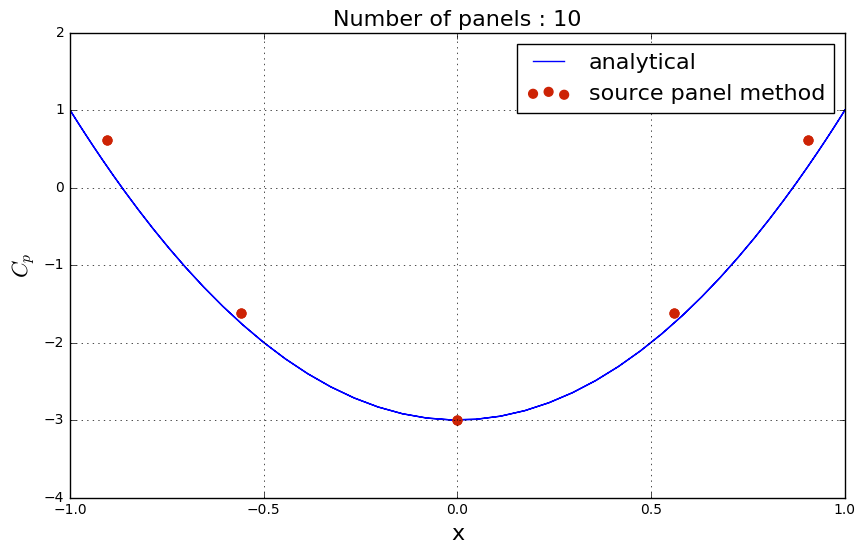

In [12]:
# calculates the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

##### Challenge task

Now that we have computed the pressure coefficient on the surface of the cylinder, it will be interesting to visualize what the streamlines look like.

To do that, we use the function `streamplot()` from Matplotlib, requiring the Cartesian velocity components (`u`,`v`) on a mesh grid (`X`,`Y`). Therefore, the first step is to derive the equations for the velocity components.

The potential at point $\left(x,y\right)$ of the $N_p$ source sheets in a uniform horizontal flow $U_\infty$ is

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

And the velocity field at point $\left(x,y\right)$ is

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Your task will be to:

* derive the Cartesian velocity components
* create a mesh grid
* compute the velocity field on the mesh grid
* plot the results
* change the number of panels to improve the visualization

---

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()